In [ ]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 5.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import os
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv1D,LSTM,Bidirectional,Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tqdm
import logging
from pandas_datareader import data as pdr
import yfinance as yf

logging.getLogger('tensorflow').setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import pickle
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
OK = False
while OK == False:
  print('Renseignements actions, parmi les 5')
  lvmh = input('LVMH, montant en action\n')
  lvmh = int(lvmh)
  air_liquide = input('Air Liquide, montant en action\n')
  air_liquide = int(air_liquide)
  airbus = input('Airbus, montant en action\n')
  airbus = int(airbus)
  loreal = input("L'Oréal, montant en action\n")
  loreal = int(loreal)
  renault = input('Renault, montant en action\n')
  renault = int(renault)
  ubisoft = input('Ubisoft, montant en action\n')
  ubisoft = int(ubisoft)
  orange = input('Orange, montant en action\n')
  orange = int(orange)
  carrefour = input('Carrefour, montant en action\n')
  carrefour = int(carrefour)
  tf1 = input('TF1, montant en action\n')
  tf1 = int(tf1)
  edf = input('EDF, montant en action\n')
  edf = int(edf)
  ovh = input('OVH, montant en action\n')
  ovh = int(ovh)
  break

Renseignements actions, parmi les 5
LVMH, montant en action
2
Air Liquide, montant en action
6
Airbus, montant en action
0
L'Oréal, montant en action
1
Renault, montant en action
5
Ubisoft, montant en action
0
Orange, montant en action
0
Carrefour, montant en action
12
TF1, montant en action
0
EDF, montant en action
0
OVH, montant en action
2


In [ ]:
liste_valeur_action = [lvmh, renault, air_liquide, airbus, loreal, ubisoft, orange, carrefour, tf1, edf, ovh]
liste_nom = ['lvmh', 'renault', 'air_liquide', 'airbus', 'loreal', 'ubisoft', 'orange', 'carrefour', 'tf1', 'edf', 'ovh']

In [ ]:
def data_base():

  data_lvmh = yf.download("MC.PA", start="2021-01-01", progress=False)
  d_renault = yf.download("RNO.PA", start="2021-01-01", progress=False)
  d_air = yf.download("AI.PA", start="2021-01-01", progress=False)
  d_airbus = yf.download("AIR.PA", start="2021-01-01", progress=False)
  d_loreal = yf.download("OR.PA", start="2021-01-01", progress=False)
  d_ubi = yf.download("UBI.PA", start="2021-01-01", progress=False)
  d_orange = yf.download("ORA.PA", start="2021-01-01", progress=False)
  d_car = yf.download("CA.PA", start="2021-01-01", progress=False)
  d_tf1 = yf.download("TFI.PA", start="2021-01-01", progress=False)
  d_edf = yf.download("EDF.PA", start="2021-01-01", progress=False)
  d_ovh = yf.download("OVH.PA", start="2021-01-01", progress=False)

  return data_lvmh, d_renault, d_air, d_airbus, d_loreal, d_ubi, d_orange, d_car, d_tf1, d_edf, d_ovh

In [ ]:
def params(df):
  data = df[['Close']]
  time = [i for i in range(len(data))]
  split_time = round(len(data)*0.8)
  data_ = [i for i in data.Close]

  window_size = 10# on prend 10 valeurs pour prédire la 11eme
  batch_size = 8
  return data_, time, split_time, window_size, batch_size

In [ ]:
def transform_train_test(data_autre):
  data_d = params(data_autre)[0]
  split_time = params(data_autre)[2]
  time = params(data_autre)[1]
  window_size = params(data_autre)[3]
  batch_size = params(data_autre)[4]

  test = data_d[split_time:]
  time_test = time[split_time:]

  train = data_d[:split_time]
  time_train = time[:split_time]

  train_df = tf.data.Dataset.from_tensor_slices(train)
  train_df = train_df.window(window_size + 1,shift=1,drop_remainder=True)
  train_df = train_df.flat_map(lambda window : window.batch(window_size + 1))
  train_df = train_df.map(lambda x : (x[:-1],x[-1]))
  train_df = train_df.batch(batch_size,drop_remainder=True).prefetch(1)

  test_df = tf.data.Dataset.from_tensor_slices(test)
  test_df = test_df.window(window_size,shift=1,drop_remainder=True)
  test_df = test_df.flat_map(lambda window : window.batch(window_size))
  test_df = test_df.batch(1)

  return test_df, train_df, time_test, time_train, test

In [ ]:
def modelisation():
  model = tf.keras.models.load_model('/content/model.h5')
  return model

In [ ]:
def prediction(data_autre):
  model = modelisation()
  test_df = transform_train_test(data_autre)[0]
  
  pred = model.predict(test_df)
  final_pred = [pred[i][0] for i in range(len(pred))]

  return final_pred

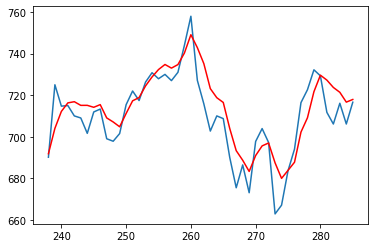

In [ ]:
data_autre = data_base()[0]
time_test = transform_train_test(data_autre)[2]
test = transform_train_test(data_autre)[4]
pred = prediction(data_autre)

plt.plot(time_test[10-1:],test[10-1:])#-1 car il commence a 0
plt.plot(time_test[10-1:],pred,color='red')# graphique montrant la prédiction et les données tests

In [ ]:
def predictions_futures(data_autre):

  window_size = params(data_autre)[3]
  model = modelisation()
  test = transform_train_test(data_autre)[4]
  der_val = list()

  next_clo = test[-window_size:]
  df_pred_next = tf.data.Dataset.from_tensor_slices(next_clo)
  df_pred_next = df_pred_next.window(window_size,shift=1,drop_remainder=True)
  df_pred_next = df_pred_next.flat_map(lambda window : window.batch(10))
  df_pred_next = df_pred_next.batch(1)

  der_val.append(test[-1])
  for i in range(5):#prediction 5 jours
    test_df = transform_train_test(data_autre)[0]

    next_clo = test[-10:]
    df_pred_next = tf.data.Dataset.from_tensor_slices(next_clo)
    df_pred_next = df_pred_next.window(10,shift=1,drop_remainder=True)
    df_pred_next = df_pred_next.flat_map(lambda window : window.batch(10))
    df_pred_next = df_pred_next.batch(1)
    
    model.predict(df_pred_next)[0][0]
    test.append(model.predict(df_pred_next)[0][0])

  return test[-5:], der_val

In [ ]:
def pred_for_each_data():
  liste_pred = list()
  liste_der_val = list()
  for i in range(len(liste_valeur_action)):
    data_autre = data_base()[i]
    liste_pred.append(predictions_futures(data_autre)[0])
    liste_der_val.append(predictions_futures(data_autre)[1])
  return liste_pred, liste_der_val

In [ ]:
def mean_value():
  liste_pred = pred_for_each_data()[0]
  for i in range(len(liste_pred)):
    liste_pred[i] = [elem *liste_valeur_action[i] for elem in liste_pred[i]]
  evolution_port = list(tf.reduce_sum(liste_pred, axis=0).numpy())
  time_port = [i for i in range(len(evolution_port))]
  return evolution_port, time_port

In [ ]:
def indication_action():
  derniere_valeur = list()
  derniere_pred = list()
  indica = list()
  dico_indic = dict()

  ma_liste, ma_liste2 = pred_for_each_data()
  for i in range(len(ma_liste2)):
    derniere_pred.append(ma_liste2[i][-1])

  for i in range(len(ma_liste)):
    derniere_valeur.append(ma_liste[i][0])

  for i in range(len(derniere_pred)):
    if derniere_pred > derniere_valeur:
      indica.append('Haussier')
    else:
      indica.append('Baissier')

  for ind, nom in zip(indica, liste_nom):
    dico_indic[nom]= ind

  return dico_indic

In [ ]:
def result():
  y,x = mean_value()
  plt.plot(x, y, color='red')#1 minutes 30 pour tourner
  plt.title('Evolution du portefeuille pour les 5 prochains jours')
  print(indication_action())

{'lvmh': 'Baissier', 'renault': 'Baissier', 'air_liquide': 'Baissier', 'airbus': 'Baissier', 'loreal': 'Baissier', 'ubisoft': 'Baissier', 'orange': 'Baissier', 'carrefour': 'Baissier', 'tf1': 'Baissier', 'edf': 'Baissier', 'ovh': 'Baissier'}


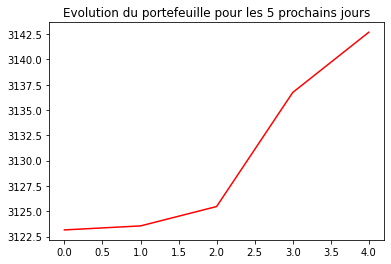

In [ ]:
result()

# Evolution du portefeuille lors du dernier mois

## Par action

In [ ]:
def evol_last_month():
  valeur_port = list()
  data_lvmh, d_renault, d_air, d_airbus, d_loreal, d_ubi, d_orange, d_car, d_tf1, d_edf, d_ovh = data_base()
  i=0
  for data in data_base():
    data = params(data)[0]
    list_value = data[-30:]
    list_value = [val*liste_valeur_action[i] for val in list_value]
    valeur_port.append(list_value)
    i+=1
  return valeur_port

In [ ]:
liste = evol_last_month()
la_liste = list()
label=list()
for i in range(len(liste)):
  if liste[i][0]!=0:
    la_liste.append(liste[i])
    label.append(liste_nom[i])

In [ ]:
temps = [i for i in range(30)]

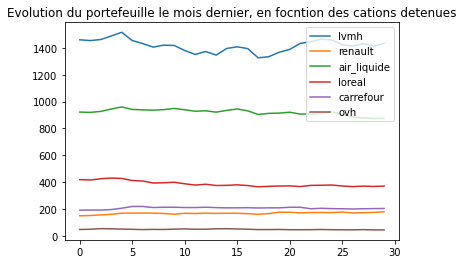

In [ ]:
for i in range(len(la_liste)):
  plt.plot(temps,la_liste[i], label=label[i])
  plt.legend(loc="upper right")
  plt.title('Evolution du portefeuille le mois dernier, en focntion des cations detenues')

## Toutes les actions confondues

In [ ]:
mon_portf = list(tf.reduce_sum(liste, axis=0).numpy())

Text(0.5, 1.0, 'Evolution du portefeuille le dernier mois')

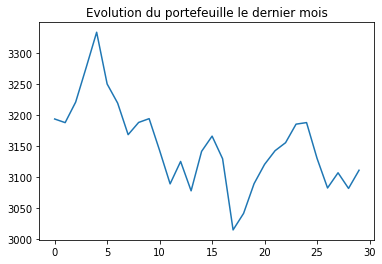

In [ ]:
plt.plot(temps, mon_portf)
plt.title('Evolution du portefeuille le mois dernier')

# Test d'autres modeles

In [ ]:
train_df = transform_train_test(data_base()[2])[1]
model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv1D(filters=32, kernel_size=3,
    #                   strides=1,
    #                   activation="relu",
    #                   input_shape=[10, 1], padding='causal'),
    tf.keras.layers.LSTM(32, input_shape=[10,1],return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False)),
    # tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
  ])
model.compile(loss=tf.keras.losses.Huber(), metrics = ['mae'], optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.7))
model.fit(train_df,epochs=200, verbose = 1)

In [ ]:
# train_df = transform_train_test(data_base()[2])[1]
test_df = transform_train_test(data_base()[2])[0]
  
pred = model.predict(test_df)
final_pred = [pred[i][0] for i in range(len(pred))]

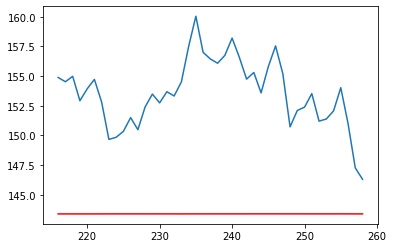

In [ ]:
time_test = transform_train_test(data_base()[2])[2]
test = transform_train_test(data_base()[2])[4]

plt.plot(time_test[10-1:],test[10-1:])#-1 car il commence a 0
plt.plot(time_test[10-1:],final_pred,color='red')